In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip -uq '/content/drive/My Drive/COVID_XRAY/548681_1157383_bundle_archive.zip' -d "/content/drive/My Drive/COVID_XRAY/Kaggle data"

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# https://www.kaggle.com/ffyyytt/covid-19-normal-classification

import os
imagePaths = []
for dirname, _, filenames in os.walk('/content/drive/My Drive/COVID_XRAY/Kaggle data/images/'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import cv2
import os
import keras

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers
from keras import applications
from keras.optimizers import Adam
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,Conv2D,MaxPooling2D,BatchNormalization
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tqdm import tqdm
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


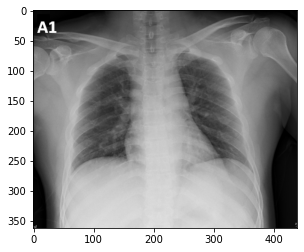

In [ ]:
image = cv2.imread(imagePaths[0])
plt.imshow(image)

In [ ]:
image.shape

(362, 439, 3)

In [ ]:
# https://www.kaggle.com/ffyyytt/covid-19-normal-classification

Data = []
Target = []
resize = 224

for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (resize, resize)) /255

    Data.append(image)
    Target.append(label)

100%|██████████| 57/57 [00:03<00:00, 16.68it/s]


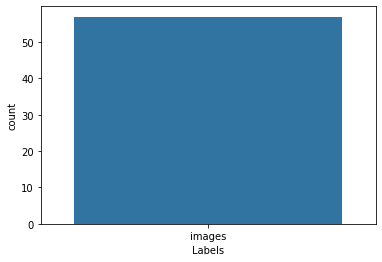

In [ ]:
df = pd.DataFrame(Target,columns=['Labels'])
sns.countplot(df['Labels'])

In [ ]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Target)
encoded_Target = encoder.transform(Target)
# convert integers to dummy variables (i.e. one hot encoded)
encoded_Target = np_utils.to_categorical(encoded_Target)

In [ ]:
encoder.classes_

array(['images'], dtype='<U6')

In [ ]:
encoded_Target[0]

array([1.], dtype=float32)

In [ ]:
#Train Test Split
X_train, X_1, y_train, y_1 = train_test_split(np.array(Data), np.array(encoded_Target), test_size=0.2, random_state=42,stratify=encoded_Target)

#Train Test Split
X_cv, X_test, y_cv, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42,stratify=y_1)

In [ ]:
del Data
del Target

In [ ]:
X_train.shape


(45, 224, 224, 3)

In [ ]:
X_cv.shape

(9, 224, 224, 3)

In [ ]:
X_test.shape

(3, 224, 224, 3)

In [ ]:
img_width = img_height = 224

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
    X_train=X_train.reshape(X_train.shape[0],3,img_width,img_height)
    X_cv=X_cv.reshape(X_cv.shape[0],3,img_width,img_height)
    X_test=X_test.reshape(X_test.shape[0],3,img_width,img_height)
    
else:
    input_shape = (img_width, img_height, 3)
    X_train=X_train.reshape(X_train.shape[0],img_width,img_height,3)
    X_cv=X_cv.reshape(X_cv.shape[0],img_width,img_height,3)
    X_test=X_test.reshape(X_test.shape[0],img_width,img_height,3)

In [ ]:
#Function to Plott train and Test loss

def plt_dynamic(x,vy,ty,ax,colors=['b']):
  ax.plot(x,vy,'b',label='Validation Loss')
  ax.plot(x,ty,'r',label='Train Loss')
  plt.legend()
  plt.grid()
  fig.canvas.draw()

In [ ]:
X_train[0]

array([[[0.45098039, 0.45098039, 0.45098039],
        [0.39607843, 0.39607843, 0.39607843],
        [0.3372549 , 0.3372549 , 0.3372549 ],
        ...,
        [0.38431373, 0.38431373, 0.38431373],
        [0.35686275, 0.35686275, 0.35686275],
        [0.32156863, 0.32156863, 0.32156863]],

       [[0.30980392, 0.30980392, 0.30980392],
        [0.2745098 , 0.2745098 , 0.2745098 ],
        [0.23921569, 0.23921569, 0.23921569],
        ...,
        [0.35294118, 0.35294118, 0.35294118],
        [0.32941176, 0.32941176, 0.32941176],
        [0.30588235, 0.30588235, 0.30588235]],

       [[0.18431373, 0.18431373, 0.18431373],
        [0.16078431, 0.16078431, 0.16078431],
        [0.14509804, 0.14509804, 0.14509804],
        ...,
        [0.32941176, 0.32941176, 0.32941176],
        [0.30588235, 0.30588235, 0.30588235],
        [0.29019608, 0.29019608, 0.29019608]],

       ...,

       [[0.61176471, 0.61176471, 0.61176471],
        [0.59607843, 0.59607843, 0.59607843],
        [0.58823529, 0

In [ ]:
#Variables defined
epoch = 25
batch = 32
num_classes=3

In [ ]:
#Model Defining
model=Sequential()

model.add(Conv2D(32,kernel_size=(3,3),
                activation='relu',
                input_shape=input_shape,
                kernel_initializer='he_normal'))  
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Dense(256,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Dense(128,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64,activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax',kernel_initializer='glorot_normal'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [ ]:
#Model Compile
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

# Train
#training = model.fit_generator(generator.flow(X_train,y_train, batch_size=batch)
                              #,epochs=epoch
                               # ,validation_data=[X_cv, y_cv]
                                #,steps_per_epoch=10,verbose=1)
his=model.fit(X_train,y_train,batch_size=batch,epochs=epoch,verbose=1,validation_data=(X_cv,y_cv))

ValueError: ignored

In [ ]:
#Plotting Train and Validation Loss
fig,ax=plt.subplots(1,1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Binary Cross Entropy')

x=list(range(1,epoch+1))

vy=his.history['val_loss']
ty=his.history['loss']
plt_dynamic(x,vy,ty,ax)

In [ ]:
#Test Accuracy
score=model.evaluate(X_test,y_test,verbose=0)
print("The test accuracy for the model is %f "%(score[1]*100))

In [ ]:
y_pred=model.predict(X_test).round()

In [ ]:
encoder.classes_

In [ ]:
#Plotting Confusion Matrix
x=confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
Cm_df=pd.DataFrame(x,index=encoder.classes_,columns=encoder.classes_)

sns.set(font_scale=1.5,color_codes=True,palette='deep')
sns.heatmap(Cm_df,annot=True,annot_kws={'size':16},fmt='d',cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix')

In [ ]:
from keras.models import load_model

model.save('my_model_v1.h5') 